In [1]:
try:
  import google.colab
  _isColab = True
except:
  _isColab = False
print('You are on Colab: ', _isColab)

You are on Colab:  False


In [2]:
if _isColab:
    %pip install monai nilearn siibra

In [69]:
import os, sys
from sys import platform
if _isColab:
    _base_path = '/content'
else:
    _base_path = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1]) + '/'
sys.path.append(_base_path)
import siibra
import nibabel as nib
from nilearn import plotting, datasets, image
import numpy as np
import matplotlib.pyplot as plt
from src.modules.postprocessing import get_affected_areas

In [70]:
atlas = siibra.atlases['human']
parcellations = list(atlas.parcellations)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"INDEX":<8}{"PARCELLATIONS NAME":<20}\n')
print(''.join(['> ' for i in range(40)]))
for i, p in enumerate(parcellations):
	print(f'{i:<8}{p.name:<20}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

INDEX   PARCELLATIONS NAME  

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
0       Deep white matter fibre bundles
1       Superficial fibre bundles
2       Cortical layer segmentation of the BigBrain model
3       DiFuMo Atlas (1024 dimensions)
4       DiFuMo Atlas (128 dimensions)
5       DiFuMo Atlas (256 dimensions)
6       DiFuMo Atlas (512 dimensions)
7       DiFuMo Atlas (64 dimensions)
8       Desikan-Killiany Atlas (2006)
9       Isocortex Segmentation
10      Julich-Brain Cytoarchitectonic Atlas (v1.18)
11      Julich-Brain Cytoarchitectonic Atlas (v2.9)
12      Julich-Brain Cytoarchitectonic Atlas (v3.0.3)
13      [PRERELEASE] Julich-Brain Cytoarchitectonic Atlas (v3.1)
14      MarsAtlas cortical parcellation model
15      Atlas of the short fiber bundles inferred from the Human Connectome Project diffusion MRI dataset
16      Virtual Epileptic Patient Atlas


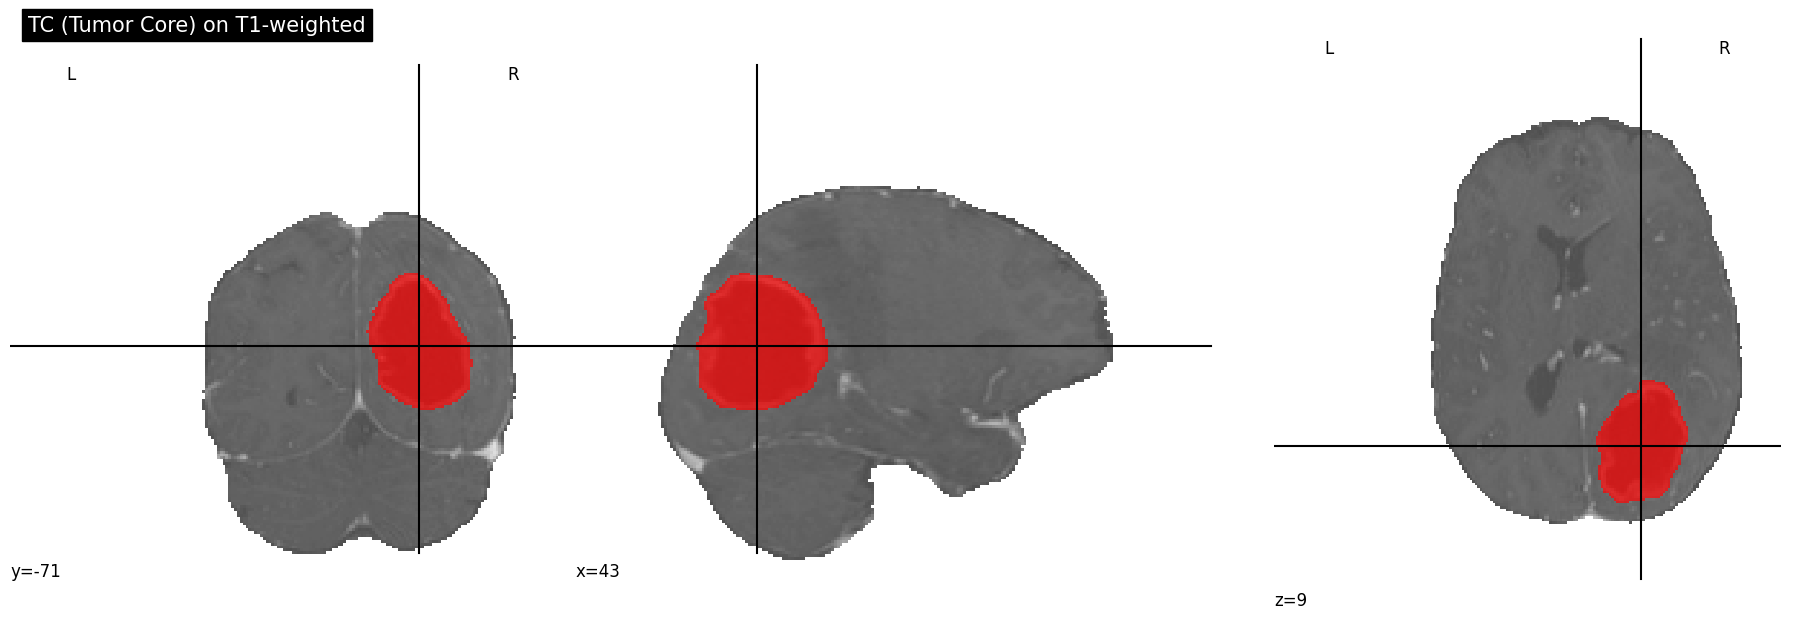

In [5]:
# NOTE: testing code to be optimized.

mask = nib.load('/Users/albertogvalerio/wa/python_playground/brain-tumor-segmentation/predictions/SegResNet_sample_2_pred.nii.gz')
img = nib.load('/Users/albertogvalerio/wa/python_playground/brain-tumor-segmentation/predictions/SegResNet_sample_2_image.nii.gz')

mask_data = mask.get_fdata()
et = mask_data[0]
tc = mask_data[1]
wt = mask_data[2]

mni_template = datasets.load_mni152_template()
pred = nib.Nifti1Image(np.rot90(tc, 2), affine=mni_template.affine)
bg = nib.Nifti1Image(img.get_fdata()[0], affine=mni_template.affine)
pred_norm = image.resample_to_img(pred, mni_template)
bg_norm = image.resample_to_img(bg, mni_template)

fig = plt.figure(figsize=(18, 6))
plotting.plot_roi(roi_img=pred_norm, bg_img=bg_norm, title='TC (Tumor Core) on T1-weighted', cmap='rainbow', figure=fig, black_bg=False)
plotting.show()

In [71]:
points = siibra.PointSet(tuple(zip(*np.where(pred_norm.get_fdata() == 1))), space='mni152', sigma_mm=5).transform(mni_template.affine, space='mni152')
plotting.view_markers(list(map(tuple, points)), marker_color='red', marker_size=1, title='TC (Tumor Core)')

In [9]:
areas = get_affected_areas(
	parcellation=parcellations[12].name,
	volume=points,
	top=5,
	verbose=False
)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                                  REGION     %_of_TUMOR    %_of_REGION

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
     Temporal-to-Parietal (GapMap) right          49.22          15.55
                 Area hOc4la (LOC) right          14.64          89.44
                 Area hOc4lp (LOC) right          12.62          84.20
                   Area hIP4 (IPS) right           6.36          97.44
                    Area PGp (IPL) right           4.98          22.97


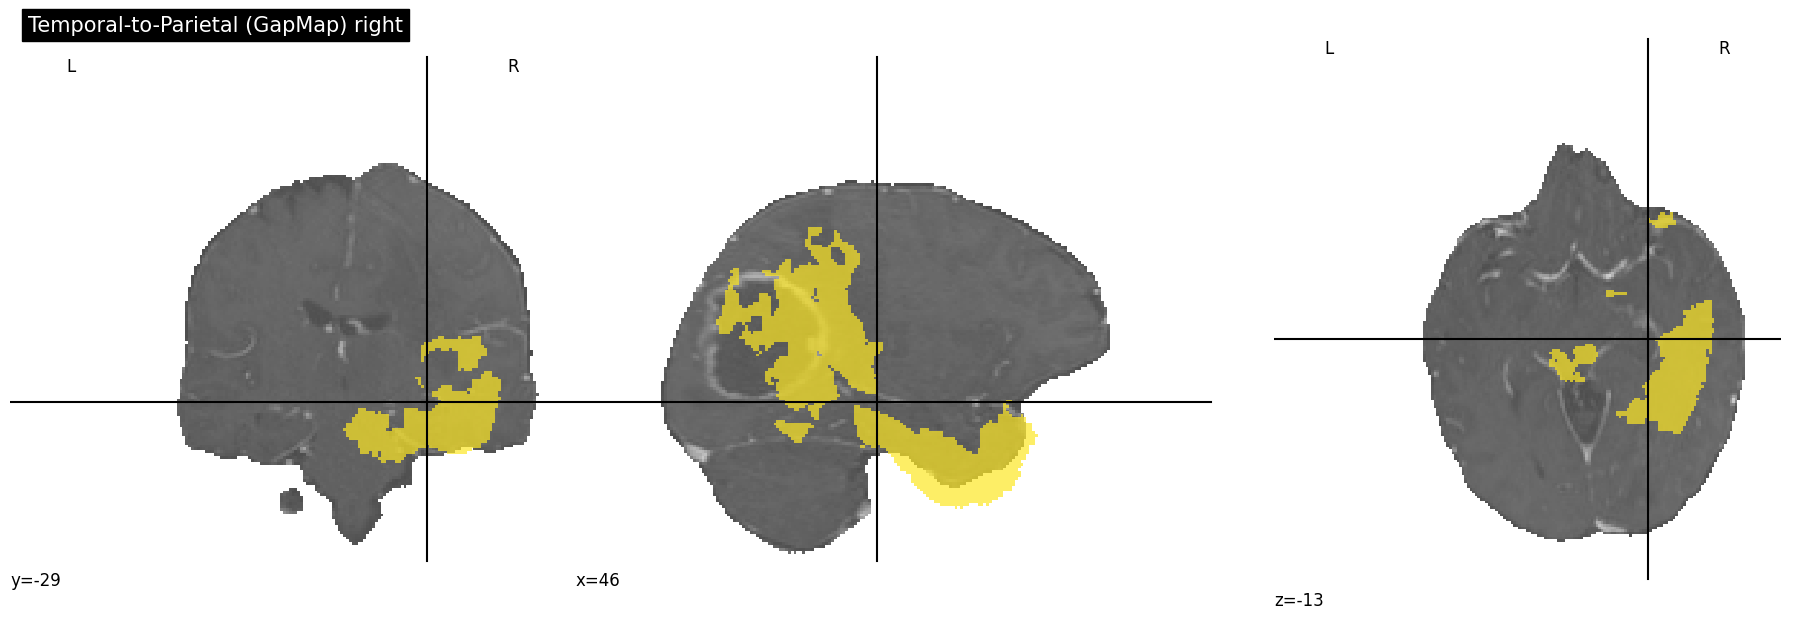

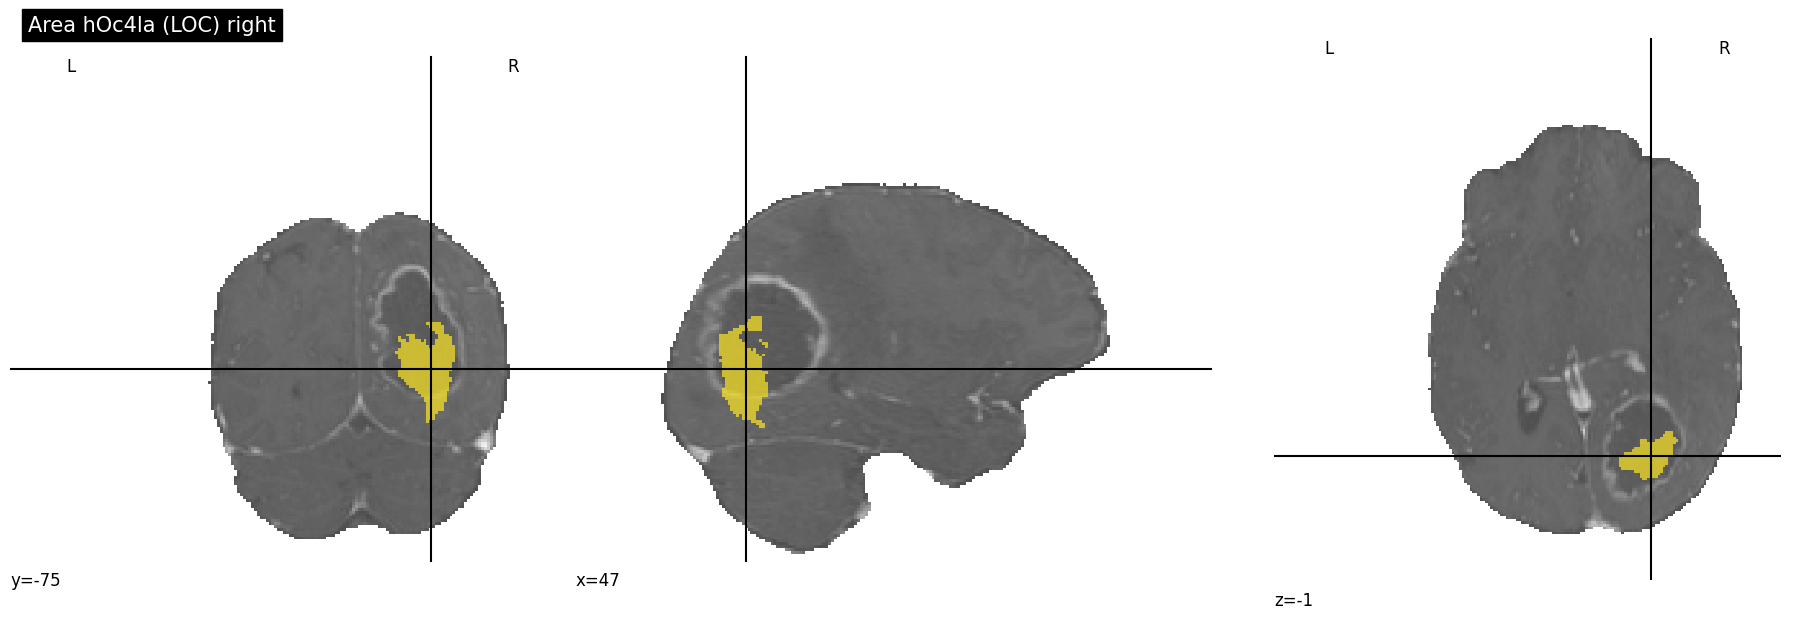

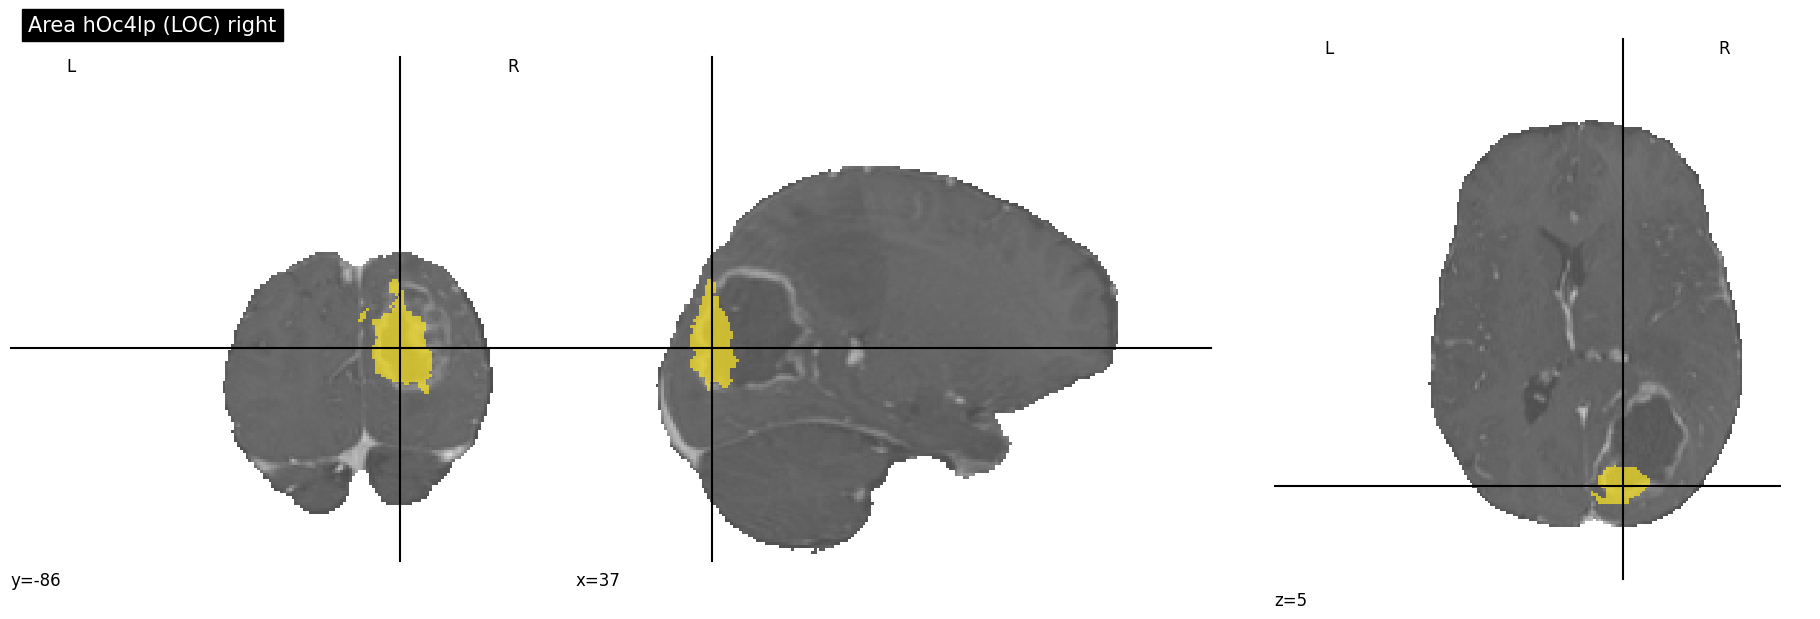

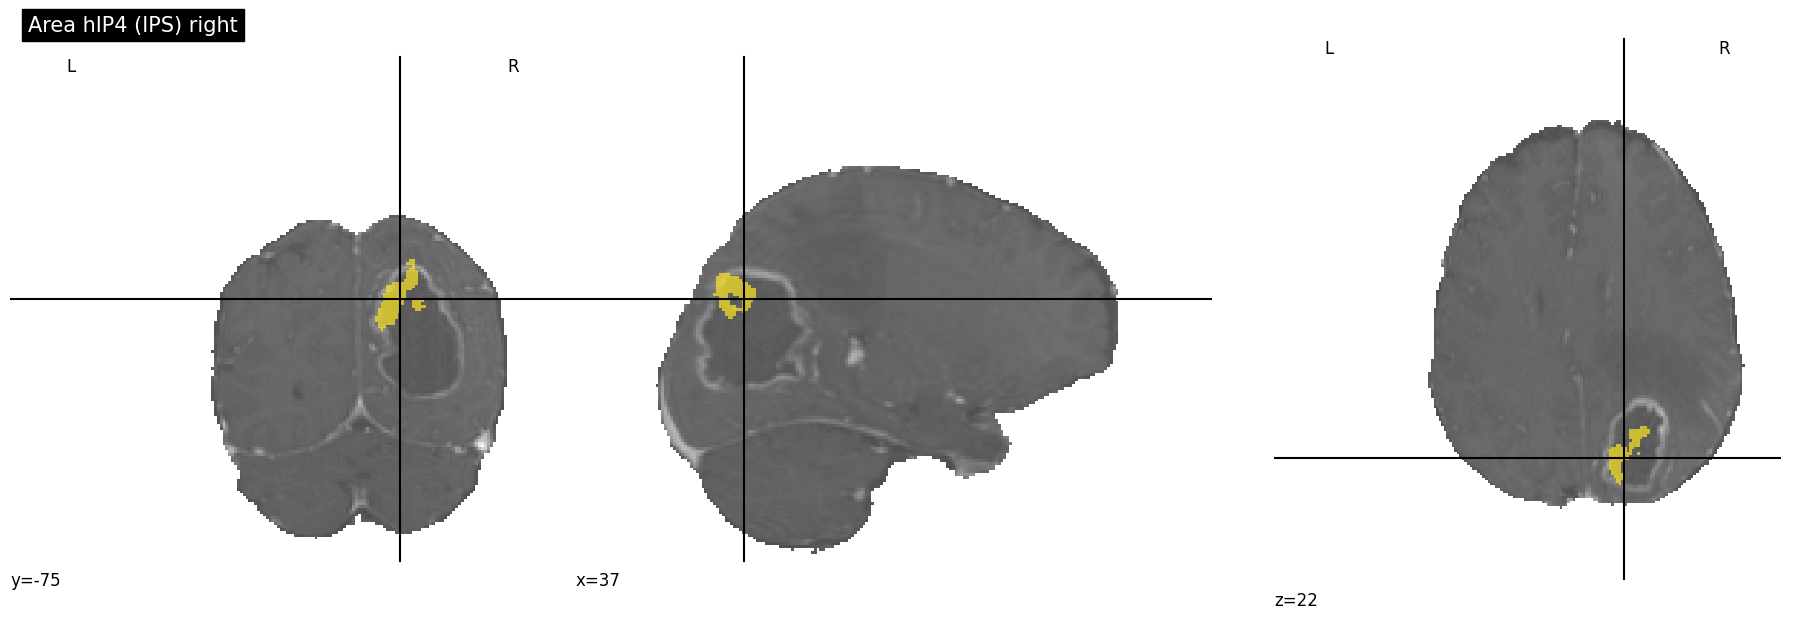

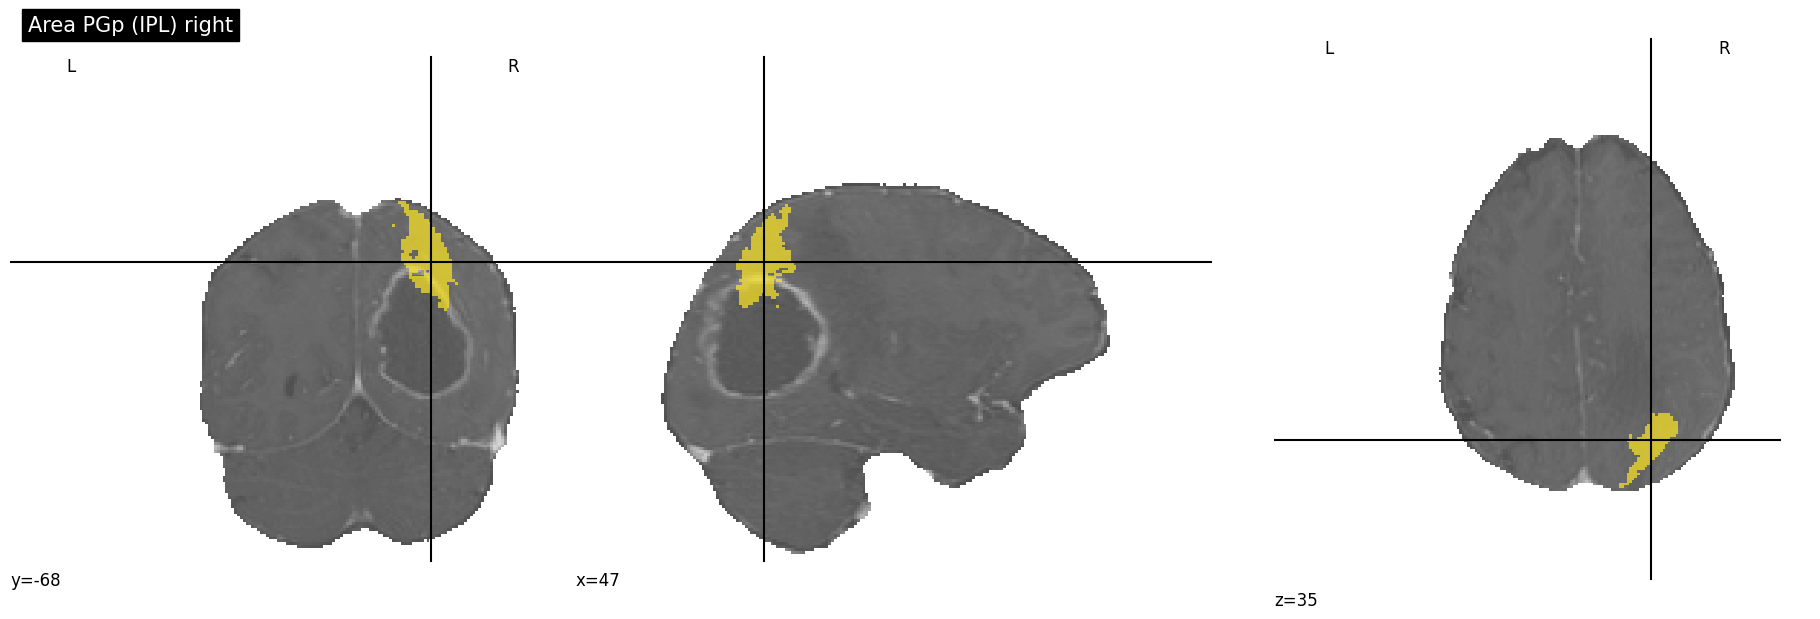

In [72]:
julich_pmaps = siibra.get_map(
	parcellation=siibra.parcellations.get(parcellations[12].name),
	space=siibra.spaces.get('mni152'),
	maptype=siibra.MapType.LABELLED
)
for a in areas:
	fig = plt.figure(figsize=(18, 6))
	plotting.plot_roi(
		roi_img=julich_pmaps.fetch(region=a),
		bg_img=bg_norm,
		title=a,
		cmap='viridis',
		black_bg=False,
		figure=fig)
	plotting.show()